## Machine Learning


This notebook contains predictions of taxi coint for each tile of the map. 


I decided to create a non-homogeneous model, such that for each tile of the tessellation a separate model is built. More explanation below..


Decided to go with classical linear model with Lasso... Features are numbers of taxis in all tiles in previous timestep. Therefore there are $25*25$ features for each model. This should create more interpretable models.



Note: Linear regression is certainly weird here as our samples are definitely not i.i.d :)



### Experiment setup


    1) Goal is to predict the number of cars in each tile of tessallation.
    
    2) Learn lasso regression model for each tile separately. 
    
        2.1) Training data is all counts of taxis from 30 minutes ago 
        2.2) Label is the number of cars for current timestamp for the specific tile
    
    
    4) First evaluate model by finding total number of cars
    
    5) Second, evaluate model for some specific high-density tiles.
  

In [1]:
import sys
sys.path.append("../") # Add parent dir to source
import pandas as pd
import numpy as np

import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime
from tqdm.notebook import tqdm # Progress bar


pd.set_option('mode.chained_assignment', None)

In [2]:
from sklearn.linear_model import Lasso
import random

random.seed(0)

In [3]:
from common import haversine_np, RectangularTessellation
df = pd.read_pickle("../processed_data/fully_processed.pkl")

In [4]:
# Create tessellation again.

min_lat = 39.76158
max_lat = 40.03603
min_long = 116.19549
max_long = 116.56628

grid_size = 25
tess = RectangularTessellation(min_lon=min_long, 
                               min_lat=min_lat, 
                               max_lon=max_long,
                               max_lat=max_lat,
                               size=grid_size)

In [5]:
# Lets look at all days data now...
monday_data = df[df["time"].dt.day == 4]
tuesday_data = df[df["time"].dt.day == 5]
# Map data to grid
monday_data["grid_x"], monday_data["grid_y"] = tess.map_to_grid(monday_data["long"], monday_data["lat"])
tuesday_data["grid_x"], tuesday_data["grid_y"] = tess.map_to_grid(tuesday_data["long"], tuesday_data["lat"])
monday_data.head()

,taxi_id,time,long,lat,grid_x,grid_y
188,1,2008-02-04 10:45:00,116.53787,39.91500,23,13
189,1,2008-02-04 10:55:00,116.50839,39.90916,21,13
190,1,2008-02-04 11:05:00,116.50940,39.90679,21,13
191,1,2008-02-04 17:28:00,116.47511,39.91397,18,13
192,1,2008-02-04 17:38:00,116.51175,39.91550,21,14


## Features

I decided to go with 30 min samplings again and pick earliest sample. This is not the best way, but I'll keep it like this for simplicity. As we saw in the previous notebook with 30 min sampling there can be big changes in locations.

I'll get data for both Monday and Tuesday. I want to check if we can model Tuesday's data based on Monday's. From 4th notebook (second exploration), I saw that the numbers were pretty similar for Monday and Tuesday.

In [6]:
first_each_half_hour_monday = (monday_data
                        .set_index("time")
                        .groupby(["taxi_id", pd.Grouper(freq="30min")])
                        .first().reset_index())

first_each_half_hour_tuesday = (tuesday_data
                        .set_index("time")
                        .groupby(["taxi_id", pd.Grouper(freq="30min")])
                        .first().reset_index())



all_occurrences_by_time_monday = []
all_occurrences_by_time_tuesday = []

for k, v in first_each_half_hour_monday.groupby("time"):
    v["grid_x"], v["grid_y"] = tess.map_to_grid(v["long"], v["lat"])
    occs = tess.calculate_occurrences_by_grid_slot(v)
    occs["time"] = k
    all_occurrences_by_time_monday.append(occs)

for k, v in first_each_half_hour_tuesday.groupby("time"):
    v["grid_x"], v["grid_y"] = tess.map_to_grid(v["long"], v["lat"])
    occs = tess.calculate_occurrences_by_grid_slot(v)
    occs["time"] = k
    all_occurrences_by_time_tuesday.append(occs)


In [7]:
all_occurrences_by_time_monday[3]

,grid_x,grid_y,count,grid_nr,time
0,0,0,1,0,2008-02-04 01:30:00
1,0,1,0,25,2008-02-04 01:30:00
2,0,2,0,50,2008-02-04 01:30:00
3,0,3,1,75,2008-02-04 01:30:00
4,0,4,3,100,2008-02-04 01:30:00
...,...,...,...,...,...
620,24,20,1,524,2008-02-04 01:30:00
621,24,21,2,549,2008-02-04 01:30:00
622,24,22,2,574,2008-02-04 01:30:00
623,24,23,2,599,2008-02-04 01:30:00


From the list of samples above, we can now train our models:


    Predict counts for all_occurrences_by_time[i+1] from all_occurrences_by_time[i]
    
    Can also predict using [i] and [i-1]! - Multiple previous time slots. 
    
    
We will take a closer look at slot 442 using coefficients.
    
    
The features are numbered as following:
![Features](features.png)


### Extract features for each time slot

In [8]:
def extract_features(cdf):
    """
    Extracts features (counts)
    """
    features = np.array(cdf.sort_values("grid_nr")["count"])
    return features


all_features_monday = {}
all_features_tuesday = {}

for i, occs in enumerate(all_occurrences_by_time_monday):
    all_features_monday[i] = extract_features(occs)
    
for i, occs in enumerate(all_occurrences_by_time_tuesday):
    all_features_tuesday[i] = extract_features(occs)

In [9]:
label_dict_monday = {}
label_dict_tuesday = {}

for grid_nr in range(grid_size**2):
    y_0 = [all_features_monday[j][grid_nr] for j in range(1,48)] # For every day
    label_dict_monday[grid_nr] = y_0
    
    
for grid_nr in range(grid_size**2):
    y_0 = [all_features_tuesday[j][grid_nr] for j in range(1,48)] # For every day
    label_dict_tuesday[grid_nr] = y_0

In [10]:
all_models = {}

for grid_nr in range(grid_size**2):

    # model for grid_nr=0is trained with label_dict[grid_nr] as labels
    # all_features_monday[0], all_features_monday[1], .. [47]
    # Train model for grid_nr
    y = label_dict_monday[grid_nr]
    # Data for every grid. No data for last.
    X = np.array([all_features_monday[i] for i in range(0, 47)])
    lr = Lasso(tol=0.1, max_iter=10000).fit(X, y)
    all_models[grid_nr] = lr
    

/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: O

In [11]:
# Predict for every slot on Monday and Tuesday
# Clip predictions to be min 0..
predictions_monday = {}
predictions_tuesday = {}

for grid_nr in range(grid_size**2):
    monday_X = np.array([all_features_monday[i] for i in range(0, 47)])
    tuesday_X = np.array([all_features_tuesday[i] for i in range(0, 47)])
    
    # Clip predictions to be min 0...
    predictions_monday[grid_nr]  = np.clip(all_models[grid_nr].predict(monday_X), a_min=0, a_max=None)
    predictions_tuesday[grid_nr] = np.clip(all_models[grid_nr].predict(tuesday_X), a_min=0, a_max=None)
    

## How many cars are there total on Monday and Tuesday.

Sum up predictions for each tile and plot to see predictions..

In [12]:
sums_monday = [np.sum([label_dict_monday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(47)]
sum_preds_monday = [np.sum([predictions_monday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(47)]


sums_tuesday = [np.sum([label_dict_tuesday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(47)]
sum_preds_tuesday = [np.sum([predictions_tuesday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(47)]

timesteps = [i for i in range(1, 48)]

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


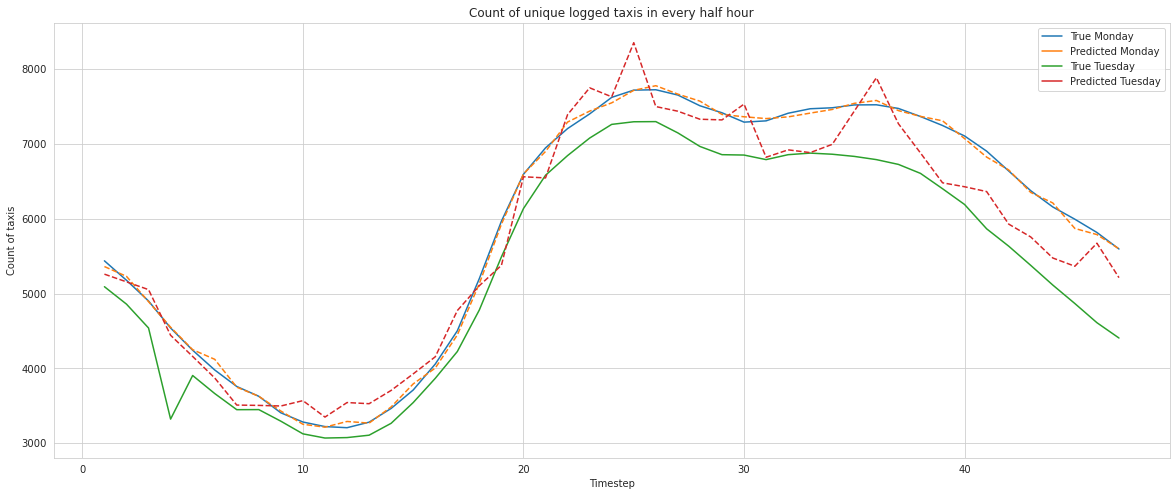

In [14]:
plt.rcParams["figure.figsize"] = (20,8)

sns.set_style("whitegrid")
axes =  sns.lineplot(x=timesteps, y=sums_monday, label="True Monday")
axes =  sns.lineplot(x=timesteps, y=sum_preds_monday, label="Predicted Monday")
axes =  sns.lineplot(x=timesteps, y=sums_tuesday, label="True Tuesday")
axes =  sns.lineplot(x=timesteps, y=sum_preds_tuesday, label="Predicted Tuesday")

axes.lines[1].set_linestyle("--")
axes.lines[3].set_linestyle("--")


plt.title("Count of unique logged taxis in every half hour")
plt.ylabel("Count of taxis")
plt.xlabel("Timestep")
plt.show()



### Results interpretation
We can see that for monday it works really well (we have nicely overfit our model to data :) ) We probably have too many degrees of freedom :) 

Also using the same models we trained on Monday and apply it for Tuesday gets some results but not as good.


What might be the problem here? Looking only at one step back we will not know the time of the day or trend. We do not know the slope of car number changing.

Note, that we are only predicting 30 minutes to the future.

### Investigating coefficients

Can we gain some insight by looking at model coefficients for each slot?

2.174654603567924


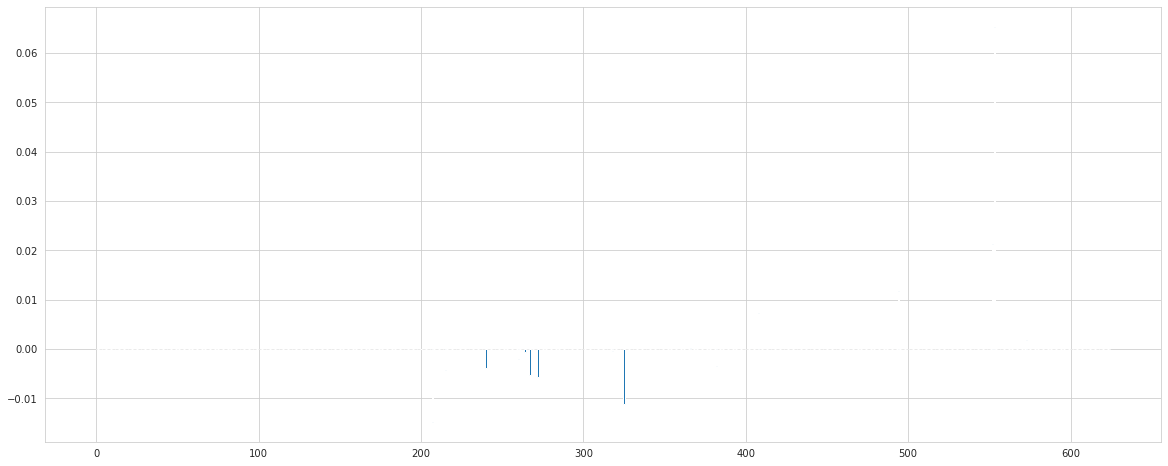

In [15]:
x_vals = [i for i in range(grid_size**2)]
print(all_models[0].intercept_)
plt.bar(x=x_vals, height=all_models[0].coef_)
plt.show()

We can see that for slot 0 (which is bottom-left) we have only some negative coefficients and an intercept of 2

#### Investigate coefficients and predictions for some more interesting places

Lets look at tile 442 which is displayed below:

![Features](features.png)

9.544545035948095


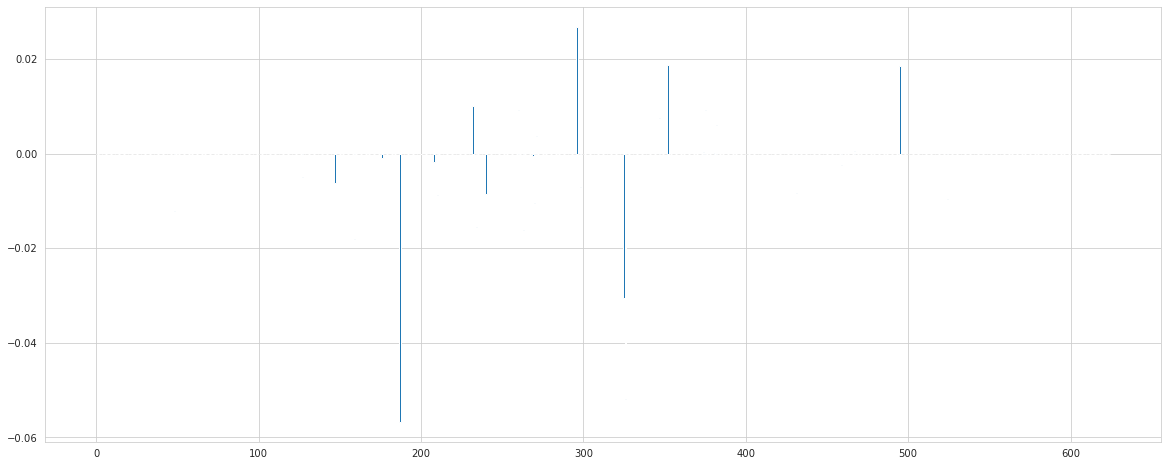

In [16]:
x_vals = [i for i in range(grid_size**2)]
print(all_models[442].intercept_)
plt.bar(x=x_vals, height=all_models[442].coef_)
plt.show()

The intercept for the model for tile 442 is 9.57 and the changes to counts come from some other tiles.

Lets see what tiles have non-zero coefficients:

In [17]:
coeffs_442_nonzero = all_models[442].coef_.nonzero()

In [18]:
coeffs_442_nonzero

(array([ 48, 127, 147, 159, 176, 187, 208, 210, 232, 234, 240, 260, 263,
        269, 270, 271, 296, 298, 325, 326, 347, 352, 374, 375, 381, 382,
        431, 459, 467, 495, 524]),)

There seems to be quite a few of them keep . Lets only look at top 8 of them (there are 8 larger spikes on the plot). Lets convert all array into abs and find indices for these most influential ones.



In [19]:
top_coeffs = np.abs(all_models[442].coef_).argsort()[-8:][::-1]
top_coeffs

array([187, 326, 325, 296, 352, 495, 159, 263])

In [20]:
all_models[442].coef_[top_coeffs]

array([-0.05677019, -0.05182744, -0.03045304,  0.02685042,  0.0187284 ,
        0.01857621, -0.01813274, -0.01621901])

Lets find coordinates for these coeffs.

In [21]:
def nr_to_pos(nr, grid_size: int) -> tuple[int, int]:
    """
    Turn grid nr back to x,y.
    
    formula is nr // grid_size for x coordinate
               nr % grid_size for y coordinate
    """
    x = np.floor_divide(nr, grid_size)
    y = np.remainder(nr, grid_size)    
    
    return np.array(list(zip(x, y)))

nr_to_pos(top_coeffs, grid_size)

array([[ 7, 12],
       [13,  1],
       [13,  0],
       [11, 21],
       [14,  2],
       [19, 20],
       [ 6,  9],
       [10, 13]])

I now went back to the picture and found them by hand :) This is the result.

With red we have positive coefficients, therefore the number of cars being in red tiles increase the number of cars in tile 442 30 minutes later.

With cyan we have negative coefficients, therefore the numberof cars being in cyan tiles decrease the number of cars in tile 442 30 minutes later.

#### Interpretation

    At first it might not make much sense. One would think that the tiles nearby affect more.
    The fact is that we are looking at 30 minutes in the future..
    
    Some cyan negative coefficients seem to be capturing traffic that is leaving the city. 
    Therefore the number of cars will decrease.
    
    The red coefficients seem to be nearby tiles or one seems to capture traffic that is entering the city.

I assume that we could model traffic flow better if we consider much faster sampling :) 30 minutes might be enough time to drive through the city itself during some times of the day!

![Features](tile_442.png)

## Two previous timesteps

Practically the same as above, but attempt with two timesteps.

In [22]:
all_features_monday = {}
all_features_tuesday = {}

for i, occs in enumerate(all_occurrences_by_time_monday):
    all_features_monday[i] = extract_features(occs)
    
for i, occs in enumerate(all_occurrences_by_time_tuesday):
    all_features_tuesday[i] = extract_features(occs)

label_dict_monday = {}
label_dict_tuesday = {}

for grid_nr in range(grid_size**2):
    
    # Labels are shifted by 2!
    y_0 = [all_features_monday[j][grid_nr] for j in range(2,48)] # For every day
    label_dict_monday[grid_nr] = y_0
    
for grid_nr in range(grid_size**2):
    y_0 = [all_features_tuesday[j][grid_nr] for j in range(2,48)] # For every day
    label_dict_tuesday[grid_nr] = y_0

all_models = {}


# This part is different here.. How do we choose features.
for grid_nr in range(grid_size**2):
    y = label_dict_monday[grid_nr]
    # Data for every grid. No data for last.
    X = np.array([all_features_monday[i-1] + all_features_monday[i] for i in range(1, 47)])
    lr = Lasso(tol=0.1, max_iter=10000).fit(X, y)
    all_models[grid_nr] = lr
    


# Predict for every slot on Monday and Tuesday
# Clip predictions to be min 0..
predictions_monday = {}
predictions_tuesday = {}

for grid_nr in range(grid_size**2):
    monday_X = np.array([all_features_monday[i-1] + all_features_monday[i]  for i in range(1, 47)])
    tuesday_X = np.array([all_features_tuesday[i-1] + all_features_tuesday[i]  for i in range(1, 47)])
    
    # Clip predictions to be min 0...
    predictions_monday[grid_nr]  = np.clip(all_models[grid_nr].predict(monday_X), a_min=0, a_max=None)
    predictions_tuesday[grid_nr] = np.clip(all_models[grid_nr].predict(tuesday_X), a_min=0, a_max=None)
    
    


/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
/home/joonas/anaconda3/envs/tdrive/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: O

In [23]:
sums_monday = [np.sum([label_dict_monday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(46)]
sum_preds_monday = [np.sum([predictions_monday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(46)]


sums_tuesday = [np.sum([label_dict_tuesday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(46)]
sum_preds_tuesday = [np.sum([predictions_tuesday[grid_nr][i] for grid_nr in range(grid_size**2)]) for i in range(46)]

timesteps = [i for i in range(2, 48)]


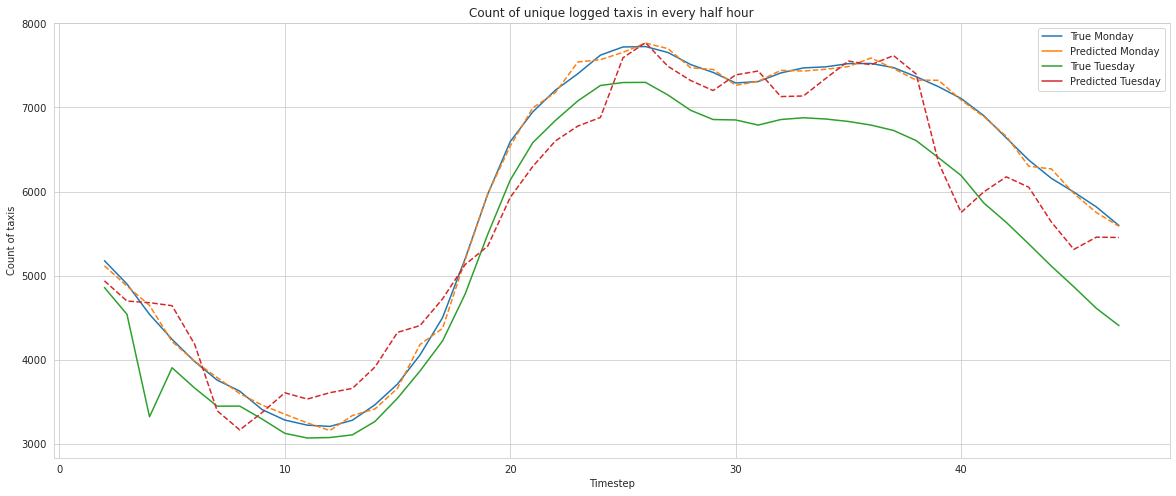

In [24]:
plt.rcParams["figure.figsize"] = (20,8)

sns.set_style("whitegrid")
axes =  sns.lineplot(x=timesteps, y=sums_monday, label="True Monday")
axes =  sns.lineplot(x=timesteps, y=np.array(sum_preds_monday), label="Predicted Monday")

axes =  sns.lineplot(x=timesteps, y=sums_tuesday, label="True Tuesday")
axes =  sns.lineplot(x=timesteps, y=np.array(sum_preds_tuesday), label="Predicted Tuesday")


axes.lines[1].set_linestyle("--")
axes.lines[3].set_linestyle("--")


plt.title("Count of unique logged taxis in every half hour")
plt.ylabel("Count of taxis")
plt.xlabel("Timestep")
plt.show()

We can actually see that using two previous timesteps the model performs a bit worse on Tuesday.

## Ran out of time here :)